In [67]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.preprocessing import prepare_data, add_lag_features, add_moving_average_features, add_seasonal_features
from src.tune_hyperparams import tune_lgbm_hyperparameters
from src.utils import plot_feature_importante, calculate_ic, plot_forecast
import seaborn as sns
sns.set_style("dark")
sns.set_palette("dark")

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy import stats
from datetime import date

import json
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
df = pd.read_csv("../data/jena_climate_2009_2016.csv")
df = prepare_data(df)
target = "temperature_celsius"
df.head()

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,days_since_beginning,year
0,2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000,0,2009
1,2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667,0,2009
2,2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667,0,2009
3,2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333,0,2009
4,2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333,0,2009


In [69]:
df_temp_sarima = pd.read_csv("../data/pred_sarima.csv")
df_temp_sarimax = pd.read_csv("../data/pred_sarimax.csv")
df_temp_lgbm = pd.read_csv("../data/pred_lgbm.csv")


df_temp_sarima["date"] = pd.to_datetime(df_temp_sarima["Unnamed: 0"])
df_temp_sarima.set_index("date", inplace=True)

df_temp_sarimax["date"] = pd.to_datetime(df_temp_sarimax["Unnamed: 0"])
df_temp_sarimax.set_index("date", inplace=True)

df_temp_lgbm["date"] = pd.to_datetime(df_temp_lgbm["date"])
df_temp_lgbm.set_index("date", inplace=True)

In [70]:
df_pred_final = pd.concat([df_temp_sarima["predicted_mean"], df_temp_sarimax["predicted_mean"], df_temp_lgbm], axis=1)
df_pred_final.columns = ["SARIMA", "SARIMAX", "temperature_celsius", "LGBM"]
df_pred_final.dropna(inplace=True)
df_pred_final

,SARIMA,SARIMAX,temperature_celsius,LGBM
date,,,,
2016-12-24 00:00:00,-0.828457,-0.683458,-0.065000,-0.032714
2016-12-24 01:00:00,-0.886611,-0.229818,0.651667,-0.308397
2016-12-24 02:00:00,-1.001848,0.106296,1.220000,-0.262524
2016-12-24 03:00:00,-1.019269,0.605808,2.646667,0.343406
2016-12-24 04:00:00,-1.010992,1.412583,3.346667,0.604908
...,...,...,...,...
2016-12-31 19:00:00,-1.089693,-2.118332,-1.356667,-1.525408
2016-12-31 20:00:00,-1.477521,-2.624210,-2.503333,-1.035382
2016-12-31 21:00:00,-1.724534,-3.395448,-2.653333,-1.727323


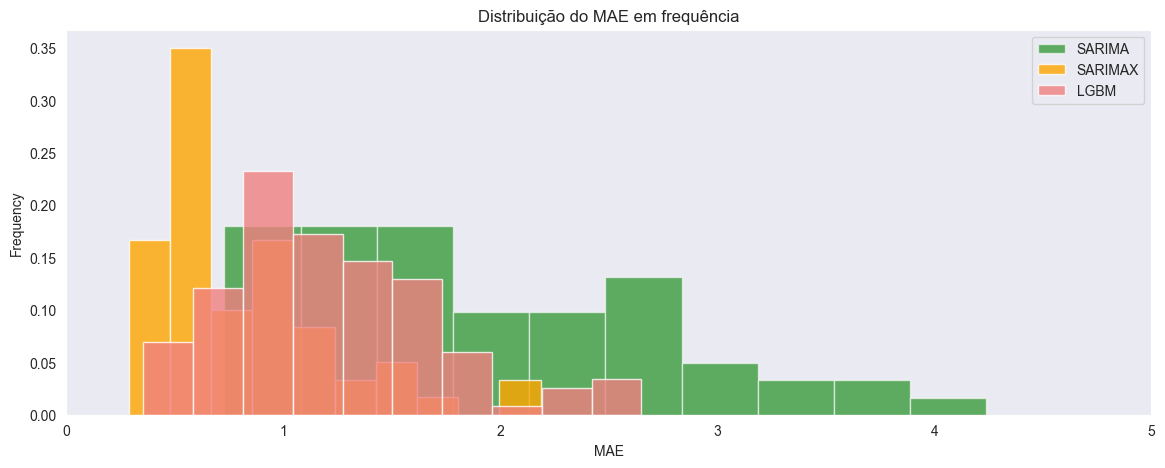

In [71]:
df_lst_mae_sarima = pd.read_csv("../data/lst_mae_sarima.csv", index_col=False)["0"]
df_lst_mae_lgbm = pd.read_csv("../data/lst_mae_lgbm.csv", index_col=False)["0"]
df_lst_mae_sarimax = pd.read_csv("../data/lst_mae_sarimax.csv", index_col=False)["0"][1:]

# df_lst_mae_lgbm.columns = ["LGBM"]
# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(14, 5))

# Plotando a área (não empilhada)
df_lst_mae_sarima.plot.hist(
    stacked=False,  # Não empilhar as áreas
    alpha=0.6,
    ax=ax,  # Usando o mesmo eixo para o gráfico de área
    label="SARIMA",  # Adicionando legenda
    color='green',
    weights=np.zeros_like(df_lst_mae_sarima) + 1. / df_lst_mae_sarima.size
)
df_lst_mae_sarimax.plot.hist(
    stacked=False,  # Não empilhar as áreas
    alpha=0.8,
    ax=ax,  # Usando o mesmo eixo para o gráfico de área
    label="SARIMAX",  # Adicionando legenda
    color='orange',
    weights=np.zeros_like(df_lst_mae_sarimax) + 1. / df_lst_mae_sarimax.size
)
df_lst_mae_lgbm.plot.hist(
    stacked=False,  # Não empilhar as áreas
    alpha=0.8,
    ax=ax,  # Usando o mesmo eixo para o gráfico de área
    label="LGBM",  # Adicionando legenda
    color='lightcoral',
    weights=np.zeros_like(df_lst_mae_lgbm) + 1. / df_lst_mae_lgbm.size
)


# # Exibindo a legenda
plt.legend(loc="upper right")  # Coloca a legenda no canto superior esquerdo

# # Exibindo o gráfico
plt.xlabel('MAE')
# plt.ylabel('Valor')
# limit xaxis
plt.xlim(0,5)
plt.title("Distribuição do MAE em frequência")
plt.show()

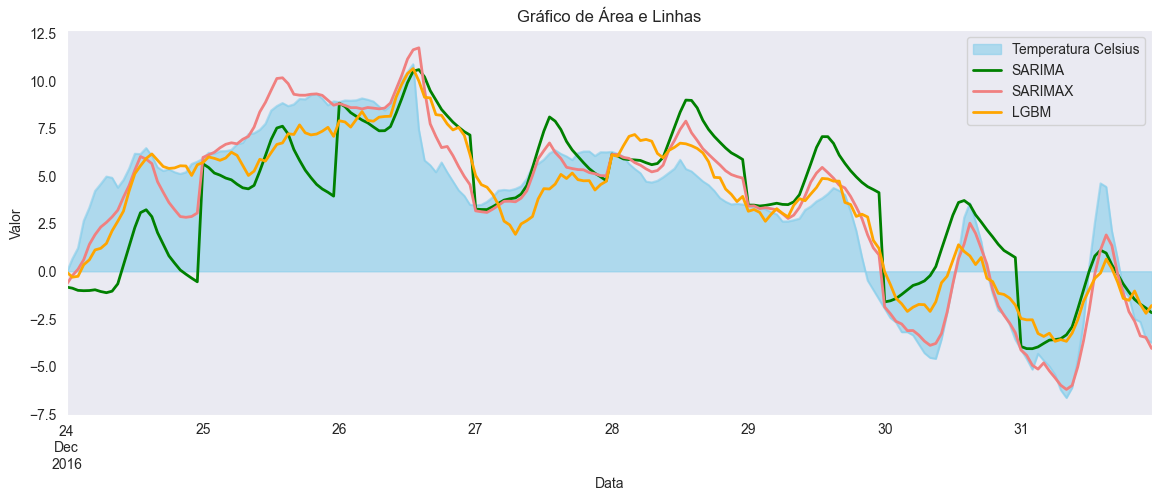

In [72]:
# Criando a figura e o eixo
fig, ax = plt.subplots(figsize=(14, 5))

# Plotando a área (não empilhada)
df_pred_final["temperature_celsius"].plot.area(
    stacked=False,  # Não empilhar as áreas
    alpha=0.6,
    ax=ax,  # Usando o mesmo eixo para o gráfico de área
    label="Temperatura Celsius",  # Adicionando legenda
    color='skyblue',
)

# Plotando as linhas com cores mais suaves e legendas personalizadas
df_pred_final[["SARIMA","SARIMAX", "LGBM"]].plot(
    ax=ax,  # Usando o mesmo eixo para as linhas
    linewidth=2,  # Espessura das linhas
    color=['green', 'lightcoral', "orange"],  # Cores mais claras para as linhas
    title='Gráfico de Área e Linhas',  # Título do gráfico
    label=["SARIMA", "LGBM"]  # Definindo os rótulos diretamente aqui
)

# Exibindo a legenda
plt.legend(loc="upper right")  # Coloca a legenda no canto superior esquerdo

# Exibindo o gráfico
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()